/Users/matthewmeeker/Summer2023/KeithDeskos/WindGenerator/fracturbulence/DataGenerator.py:140: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.DataPoints is not None and self.data_type is not "Auto":
/var/folders/tf/3r9vx3gs1bl_zr_0qg9bwrbw0000gn/T/ipykernel_73134/2183388835.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


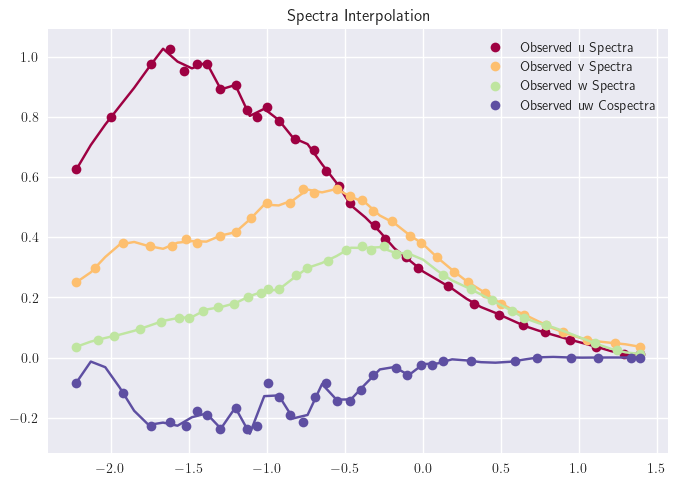

In [1]:
import numpy as np 
import csv
from pathlib import Path 
import torch 
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator



import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

from scipy.interpolate import interp1d, barycentric_interpolate, CubicSpline
from sklearn.metrics import mean_squared_error
# === Data Loading ===
# print(Path().resolve())
def extract_x_spectra(filepath):
    x, spectra = [], [] 
    with open(filepath) as spectra_csv: 
        csv_reader = csv.reader(spectra_csv, delimiter=',')
        for row in csv_reader:
            x.append(float(row[0])) 
            spectra.append(float(row[1])) 

    return np.log10(np.array(x)), np.array(spectra)

def interp_spectra(x_interp, x_true, spectra): 
    cs = CubicSpline(x_true, spectra)
    
    return cs(x_interp) 

x_coords_u, u_spectra = extract_x_spectra(Path().resolve() / "data" / "u_spectra.csv")
x_coords_v, v_spectra = extract_x_spectra(Path().resolve() / "data" / "v_spectra.csv")
x_coords_w, w_spectra = extract_x_spectra(Path().resolve() / "data" / "w_spectra.csv")
x_coords_uw, uw_cospectra = extract_x_spectra(Path().resolve() / "data" / "uw_cospectra.csv")

x_interp = np.linspace(min(x_coords_w), max(x_coords_w), 40)
# x_interp = np.linspace(-2, 2, 20)

# y_interp = barycentric_interpolate(x_coords_w, w_spectra, x_interp)
interp_u = interp_spectra(x_interp, x_coords_u, u_spectra)
interp_v = interp_spectra(x_interp,x_coords_v, v_spectra)
interp_w = interp_spectra(x_interp, x_coords_w, w_spectra)
interp_uw = interp_spectra(x_interp,x_coords_uw, uw_cospectra)

# cs = CubicSpline(x_coords_w, w_spectra)
# y_interp = cs(x_interp)
# y_cs_true = cs(x_coords_u)
# cmap = mpl.cm.get_cmap('Spectral')
cmap = plt.get_cmap('Spectral', 4)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
plt.plot(x_coords_u, u_spectra, "o", label="Observed u Spectra", color=custom_palette[0])
plt.plot(x_interp, interp_u, color=custom_palette[0])
plt.plot(x_coords_v, v_spectra, "o", label="Observed v Spectra", color=custom_palette[1])
plt.plot(x_interp, interp_v, color=custom_palette[1])
plt.plot(x_coords_w, w_spectra, "o", label="Observed w Spectra", color=custom_palette[2])
plt.plot(x_interp, interp_w, color=custom_palette[2])
plt.plot(x_coords_uw, uw_cospectra, "o", label="Observed uw Cospectra", color=custom_palette[3])
plt.plot(x_interp, interp_uw, color=custom_palette[3])

# mse_interp = mean_squared_error(y_cs_true, w_spectra)
# plt.yscale('log')
# plt.xscale('log')
# plt.title(f"MSE of Interpolant = {mse_interp}")
plt.title("Spectra Interpolation")
plt.legend()

In [6]:
from constants import consts_interp
from numpy import log

config = consts_interp.CONSTANTS_CONFIG 
config['domain'] = torch.tensor(x_interp)

k1_data_pts = config['domain'] 

pb = CalibrationProblem(**config)
parameters = pb.parameters
# TODO -- are these values reasonable??
parameters[:3] = [log(consts_interp.L), log(consts_interp.Gamma), log(consts_interp.sigma)]
pb.parameters = parameters[:len(pb.parameters)]
DataPoints = [(k1, 1) for k1 in k1_data_pts]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

DataValues = Data[1]
IECtau = MannEddyLifetime(k1_data_pts *  consts_interp.L)
kF = pb.eval(k1_data_points)

opt_params = pb.calibrate(Data=Data, **config)

['relu', 'relu']
Reading fileSpectra.dat



/Users/matthewmeeker/Summer2023/KeithDeskos/WindGenerator/fracturbulence/DataGenerator.py:140: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.DataPoints is not None and self.data_type is not "Auto":
/Users/matthewmeeker/Summer2023/KeithDeskos/WindGenerator/fracturbulence/DataGenerator.py:140: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.DataPoints is not None and self.data_type is not "Auto":
/Users/matthewmeeker/Summer2023/KeithDeskos/WindGenerator/fracturbulence/DataGenerator.py:140: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.DataPoints is not None and self.data_type is not "Auto":


FileNotFoundError: Spectra.dat not found.

In [5]:
plt.figure()

plt.plot(pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()

AttributeError: 'CalibrationProblem' object has no attribute 'loss_history_epochs'

<Figure size 800x550 with 0 Axes>